In [1]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/root/data/imagenette_wb/train/',
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=False)

number_of_classes = 10

2023-11-06 15:39:10.405380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 15:39:12.103143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 10475 images belonging to 10 classes.


In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    '/root/data/imagenette_wb/val',
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False)

Found 3925 images belonging to 10 classes.


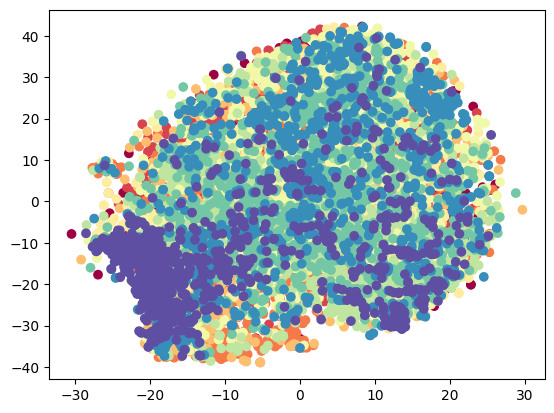

In [16]:
import matplotlib.pyplot as plt

labels_scalar = [np.argmax(label) for label in labels]
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels_scalar, cmap='Spectral')
plt.show()

In [2]:
data = []
labels = []

for _ in range(len(train_generator)):
    X_batch, y_batch = next(train_generator)
    data.extend(X_batch)
    labels.extend(y_batch)

In [4]:
from sklearn.manifold import TSNE
import numpy as np
tsne = TSNE(n_components=2)
data_np = np.array(data)
data_flat = data_np.reshape(len(data_np), -1)
data_2d = tsne.fit_transform(data_flat)

# Train from scratch

In [2]:
from keras.applications import ResNet101

model = ResNet101(weights=None,
                 include_top=True,
                 input_shape=(224, 224, 3),
                 classes=number_of_classes)

2023-11-06 15:39:47.019775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30669 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:67:02.0, compute capability: 7.0


# Using pretrained model

94765736/94765736 [==============================] - 4s 0us/step


In [3]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),  
              metrics=['acc'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=105,  # steps = total samples / batch size
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/50


2023-11-06 15:42:08.307487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-06 15:42:09.793355: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d715657400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-06 15:42:09.793396: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-11-06 15:42:09.810951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-06 15:42:10.008339: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


105/105 [==============================] - 139s 709ms/step - loss: 2.7766 - acc: 0.1047 - val_loss: 2.5271 - val_acc: 0.0000e+00
Epoch 2/50
105/105 [==============================] - 68s 641ms/step - loss: 2.5996 - acc: 0.0725 - val_loss: 2.9914 - val_acc: 0.0000e+00
Epoch 3/50
105/105 [==============================] - 68s 648ms/step - loss: 2.5400 - acc: 0.0871 - val_loss: 2.7275 - val_acc: 0.1532
Epoch 4/50
105/105 [==============================] - 68s 639ms/step - loss: 2.5028 - acc: 0.0925 - val_loss: 2.5744 - val_acc: 0.1544
Epoch 5/50
105/105 [==============================] - 68s 640ms/step - loss: 2.4631 - acc: 0.1104 - val_loss: 2.6191 - val_acc: 0.1576
Epoch 6/50
 13/105 [==>...........................] - ETA: 50s - loss: 2.5912 - acc: 0.0492

In [9]:
model.layers[-2]

In [10]:
from keras.models import Model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_extractor.predict(train_generator)

105/105 [==============================] - 56s 515ms/step


In [17]:
dis_datagen = ImageDataGenerator(rescale=1./255)
distilled_generator = dis_datagen.flow_from_directory(
    '/root/data/syn_data/imagenette/23/',
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical')

distilled_features = feature_extractor.predict(distilled_generator)

Found 1000 images belonging to 10 classes.
20/20 [==============================] - 2s 91ms/step


# Visualization

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
                                     
tsne = TSNE(random_state = 0, n_components=2,verbose=0, perplexity=40)
train_features_2d = tsne.fit_transform(train_features)

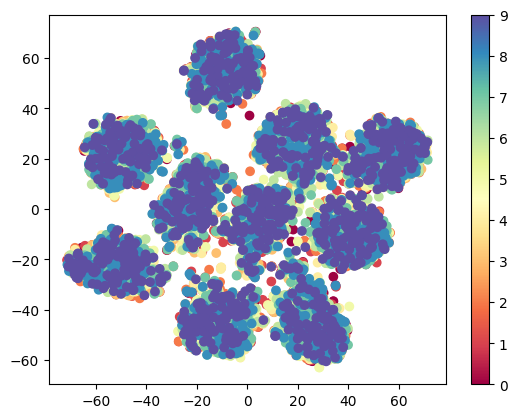

In [12]:
labels = train_generator.classes
plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=labels, cmap='Spectral')
plt.colorbar()
plt.show()

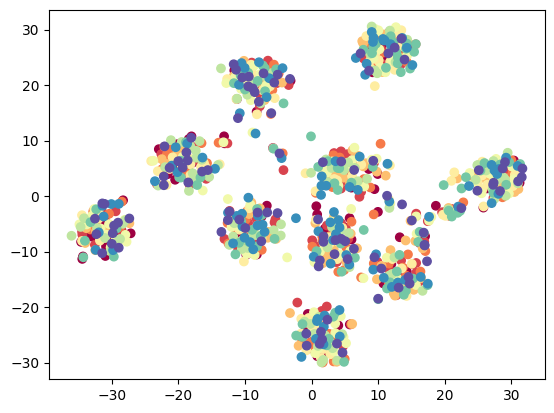

In [18]:
distilled_features_2d = tsne.fit_transform(distilled_features)
labels = distilled_generator.classes
plt.scatter(distilled_features_2d[:, 0], distilled_features_2d[:, 1], c=labels, cmap='Spectral')
plt.show()

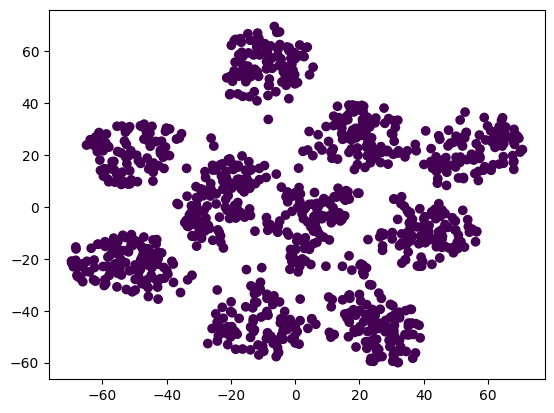

In [13]:
import numpy as np

interested_classes = [2]
indices = [i for i, label in enumerate(labels) if label in interested_classes]

selected_features = train_features_2d[indices]
selected_labels = np.array([labels[i] for i in indices])

plt.scatter(selected_features[:, 0], selected_features[:, 1], c=selected_labels)
plt.show()

## Umap

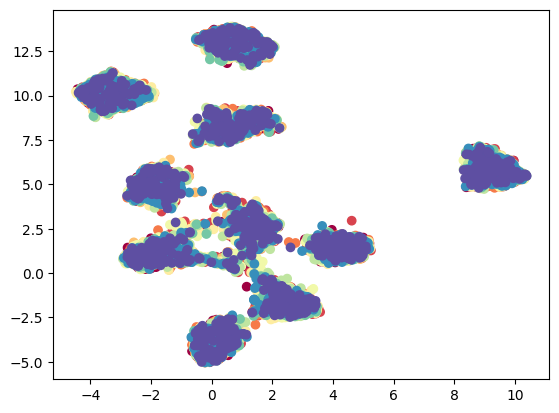

In [15]:
import umap

#Apply UMAP
reducer = umap.UMAP()
umap_results = reducer.fit_transform(train_features)

# Visualize the results
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels, cmap='Spectral')
plt.show()